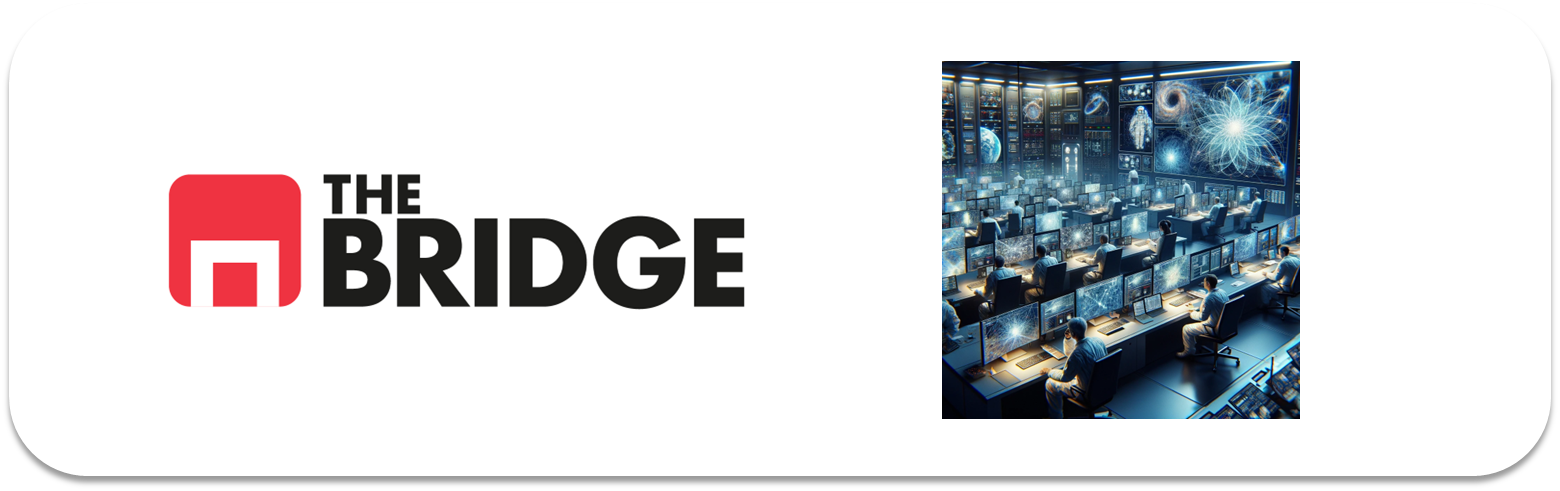

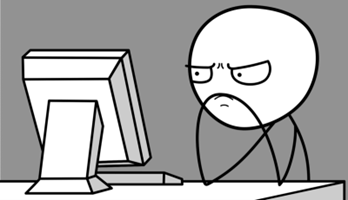

Para ejercitarte y afianzar lo aprendido sobre **Redes Convolucionales**, completa los siguientes ejercicios. Recuerda que necesitarás datos que están en el directorio data que acompaña al notebook (búscalo en el repositorio de ejercicios)
  
La solución a los mismos las tienes ya, intenta no mirarlos de primeras pero no dejes de hacerlo cuando hayas terminado por si te pudieran aportar.

### Ejercicio 0

Importa los paquetes y módulos que necesites a lo largo del notebook

In [1]:
import keras
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

from skimage.io import imread
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.models import Sequential

## El problema de "Negocio"
Para este ejercicio vas a crear un clasificador automático de paisajes. Los datos los encontrarás en https://www.kaggle.com/datasets/puneet6060/intel-image-classification?select=seg_test como `seg_train.zip` y `seg_test.zip` (o bien en el botón de download).  

NOTA: Son archivos bastante grandes (386MB en total). Por supuesto, no es necesario que tengas que mantenerlos en tu ordenador una vez realizado el ejercicio, bórralos si es el caso.




### Ejercicio 1

Cargar las imágenes. Mira cómo están almacenados los datos. Tendrás que recorrer las carpetas, cargar las imágenes en memoria y etiquetarlas con los nombres de las carpetas. Realiza un reshape de cada imagen (comienza el ejercicio con 32x32, para ir más rápido en las ejecuciones). Para ello:

1. Descarga las imagenes del repositorio de Kaggle en el directorio que vayas a emplear para el ejercicio.
2. Descomprime los datos (son ficheros de imágenes) de forma que tengas dos subdirectorios seg_train y seg_test en el que estén ya colgando directamente los directorios de cada clase de paisajes. Si descargaste seg_pred, puedes eliminarlo.
3. Crea unas variables como las siguientes (ajustándolas a tu caso/rutas particulares):

```python
ROOT_PATH = './data/'
TRAIN_PATH = ROOT_PATH + "seg_train/"
TEST_PATH = ROOT_PATH + "seg_test/"
```
4. Utiliza la siguiente función para crear los X_train, y_train y X_test e y_test:

```python
def read_data(directorio, reshape_dim = (32,32)):
    X = []
    y = []
    for folder in os.listdir(directorio):
        if os.path.isdir('/'.join([directorio, folder])):
            for file in os.listdir('/'.join([directorio, folder])):

                image = imread('/'.join([directorio, folder, file]))
                image = cv2.resize(image, reshape_dim) # Redimensionamos las imágenes a 32x32

                X.append(image)
                y.append(folder)

    return np.array(X),np.array(y)
```


*Pues copiamos lo que nos dicen y lo aplicamos a los dos directorios para tener las X y las y*

In [2]:
ROOT_PATH = './data/'
TRAIN_PATH = ROOT_PATH + "seg_train/"
TEST_PATH = ROOT_PATH + "seg_test/"

In [3]:
def read_data(directorio, reshape_dim = (32,32)):
    X = [] 
    y = []
    for folder in os.listdir(directorio):
        print(folder)
        if os.path.isdir('/'.join([directorio, folder])):
            for file in os.listdir('/'.join([directorio, folder])):

                image = imread('/'.join([directorio, folder, file]))
                image = cv2.resize(image, reshape_dim) # Redimensionamos las imágenes a 32x32

                X.append(image)
                y.append(folder)

    return np.array(X),np.array(y)

In [4]:
X_train, y_train = read_data(TRAIN_PATH)
X_test, y_test = read_data(TEST_PATH)

buildings
forest
glacier
mountain
sea
street
buildings
forest
glacier
mountain
sea
street


### Ejercicio 2

Haz la visualización del dataset: comprueba cuantos datos tienes, que forma, investiga las imágenes, comprueba con algunas muestras que has cargado bien los datos.


In [5]:
print("Dimensiones de X_train:", X_train.shape)
print("Dimensiones de y_train:", y_train.shape)
print("Dimensiones de X_test:", X_test.shape)
print("Dimensiones de y_test:", y_test.shape)

Dimensiones de X_train: (14034, 32, 32, 3)
Dimensiones de y_train: (14034,)
Dimensiones de X_test: (3000, 32, 32, 3)
Dimensiones de y_test: (3000,)


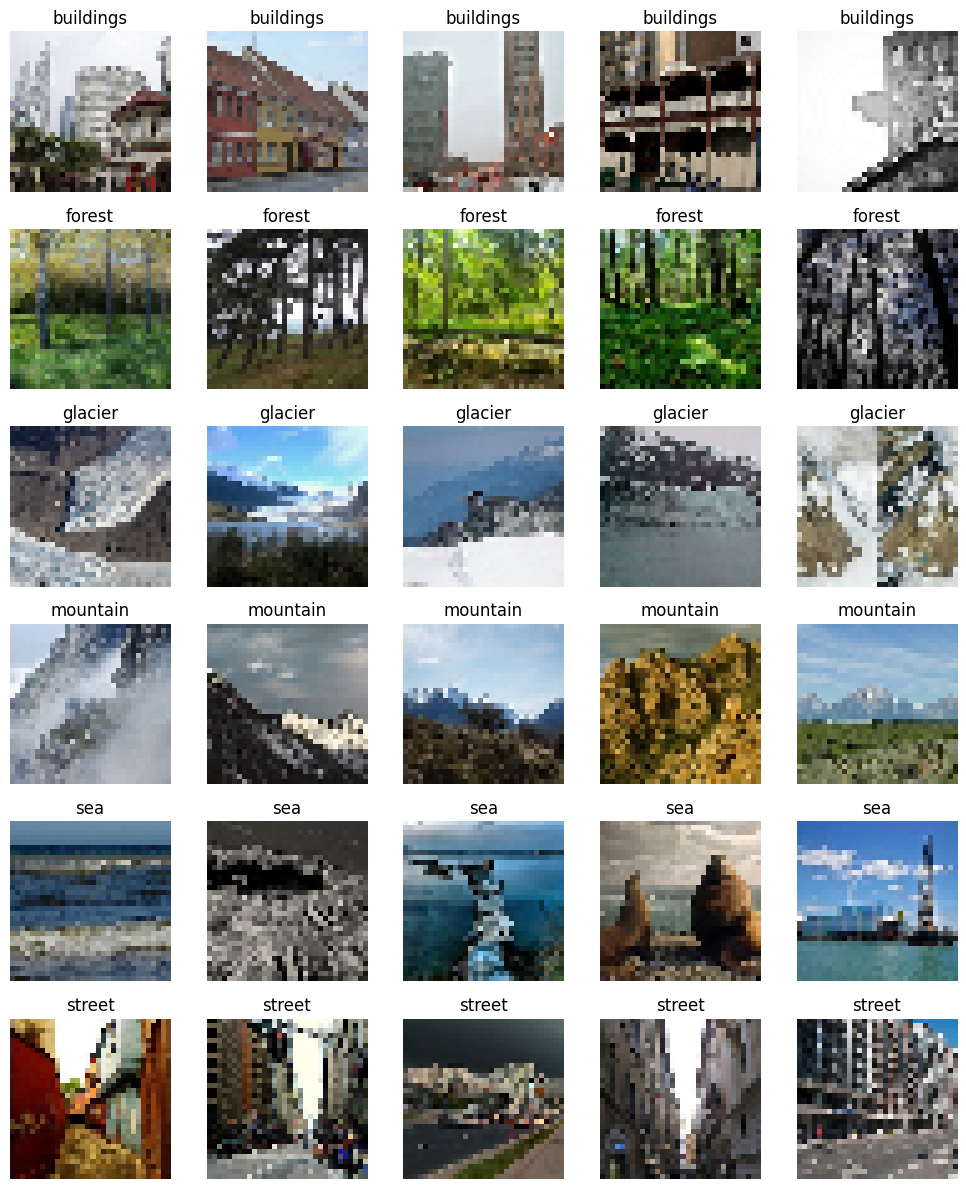

In [6]:
def visualize_samples(X, y, num_samples = 5):
    classes = np.unique(y)
    num_classes = len(classes)
    
    fig, axes = plt.subplots(num_classes, num_samples, figsize = (num_samples*2, num_classes*2))
    for i, cls in enumerate(classes):
        cls_indices = np.where(y == cls)[0]
        sample_indices = np.random.choice(cls_indices, num_samples, replace = False)
        
        for j, idx in enumerate(sample_indices):
            axes[i, j].imshow(X[idx])
            axes[i, j].set_title(cls)
            axes[i, j].axis("off")
    
    plt.tight_layout()
    plt.show()

visualize_samples(X_train, y_train)

### Ejercicio 3

Ahora haz un pequeño miniEda y normaliza las features



In [7]:
targets = pd.Series(y_train)
targets.value_counts(True)

mountain     0.178994
glacier      0.171298
street       0.169731
sea          0.162035
forest       0.161821
buildings    0.156121
Name: proportion, dtype: float64

In [8]:
X_train = X_train/255
X_test = X_test/255

### Ejercicio 4

Diseña la arquitectura de la red. Recuerda que es un algiritmo de clasificación. Ojo con las dimensiones de la entrada. Como guía, copia o parte de la arquitectura del workout (un par de capas Conv2D + MaxPooling2D con activación relu y después la fully connected layer)


In [9]:
num_classes = len(np.unique(y_train))

model = Sequential()

# Primera capa convolucional y pooling
model.add(Conv2D(32, (3, 3), activation = "relu", input_shape = (32, 32, 3)))
model.add(MaxPooling2D((2, 2)))

# Segunda capa convolucional y pooling
model.add(Conv2D(64, (3, 3), activation = "relu"))
model.add(MaxPooling2D((2, 2)))

# Capa de aplanado para conectar con las capas totalmente conectadas
model.add(Flatten())

# Capas totalmente conectadas
model.add(Dense(128, activation = "relu"))
model.add(Dense(num_classes, activation = "softmax"))

# Compilación del modelo
model.compile(optimizer = "adam",
              loss = "sparse_categorical_crossentropy",
              metrics = ["accuracy"])

# Resumen del modelo
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 30, 30, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 13, 13, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2304)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       295,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 315,206 (1.20 MB)

 Trainable params: 315,206 (1.20 MB)

 Non-trainable params: 0 (0.00 B)

### Ejercicio 5

Escoge el resto de hiperparámetros (optimizador, learning_rate, función de pérdida, métrica,...) y compila el modelo. Muestra un resumen del mismo

In [10]:
model.compile(optimizer = "adam", loss = "sparse_categorical_crossentropy", metrics = ["accuracy"])

In [11]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 30, 30, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 13, 13, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2304)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       295,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 315,206 (1.20 MB)

 Trainable params: 315,206 (1.20 MB)

 Non-trainable params: 0 (0.00 B)

### Ejercicio 6

Entrena el modelo reservando un 20% de los datos del entrenamiento para validar y con los callbacks que creas necesarios. NOTA: Ojo, tendrás que preparar un poco los X,y antes.



In [12]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.2, random_state = 42)

In [13]:
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.fit_transform(y_test)
y_val_encoded = label_encoder.transform(y_val)

In [14]:
# Callback para guardar el mejor modelo
checkpoint_callback = ModelCheckpoint(filepath = "best_model.keras", 
                                      monitor = "val_accuracy", 
                                      save_best_only = True, 
                                      mode = "max", 
                                      verbose = 1)

# Callback para detener el entrenamiento si no hay mejoras
early_stopping_callback = EarlyStopping(monitor = "val_accuracy", 
                                        patience = 5,
                                        verbose = 1, 
                                        restore_best_weights = True)

In [15]:
history = model.fit(X_train, y_train_encoded, 
                    epochs = 30,
                    batch_size = 32,
                    validation_data = (X_val, y_val_encoded),
                    callbacks = [checkpoint_callback, early_stopping_callback], 
                    verbose = 1)

Epoch 1/30
348/351 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4919 - loss: 1.2654
Epoch 1: val_accuracy improved from -inf to 0.65444, saving model to best_model.keras
351/351 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.4928 - loss: 1.2634 - val_accuracy: 0.6544 - val_loss: 0.9128
Epoch 2/30
343/351 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6864 - loss: 0.8358
Epoch 2: val_accuracy improved from 0.65444 to 0.65764, saving model to best_model.keras
351/351 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.6864 - loss: 0.8360 - val_accuracy: 0.6576 - val_loss: 0.8705
Epoch 3/30
344/351 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7288 - loss: 0.7510
Epoch 3: val_accuracy improved from 0.65764 to 0.71856, saving model to best_model.keras
351/351 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.7289 - loss: 0.7505 - val_accuracy: 0.7186 - val_loss: 0.7579
Epoch 4/30
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7589 - loss: 0.6684
Epoch 4: val_accuracy improved from 0.718


### Ejercicio 7

Representa el objeto history y comenta la evolución de tu entrenamiento.



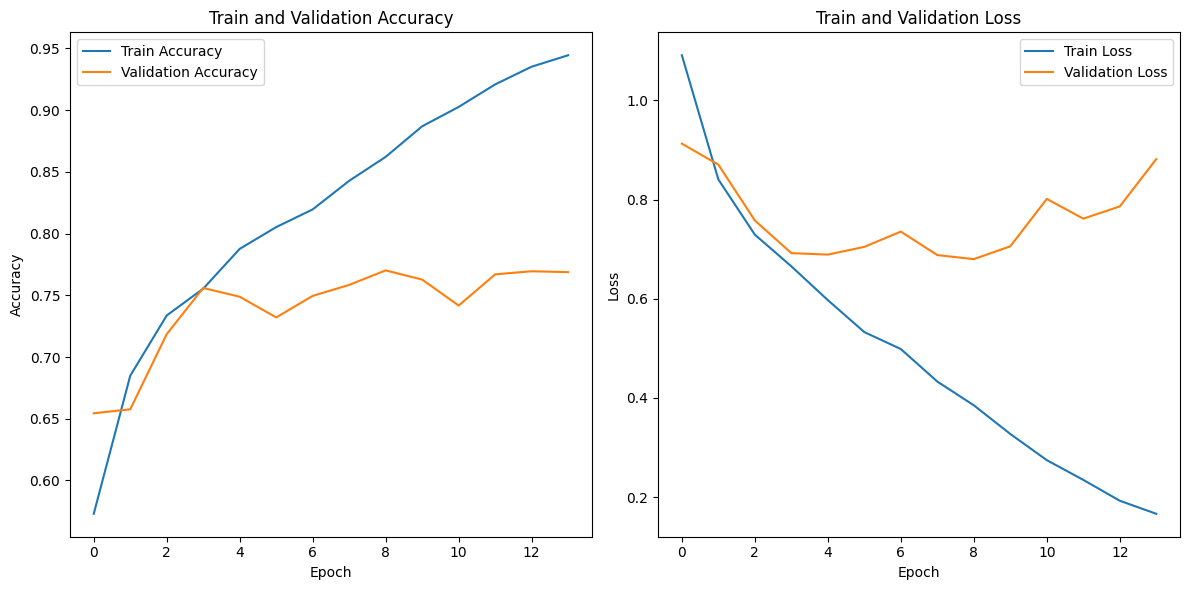

In [16]:
# Representación del objeto history
plt.figure(figsize = (12, 6))

# Precisión en el entrenamiento
plt.subplot(1, 2, 1)
plt.plot(history.history["accuracy"], label = "Train Accuracy")
plt.plot(history.history["val_accuracy"], label = "Validation Accuracy")
plt.title("Train and Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

# Pérdida en el entrenamiento
plt.subplot(1, 2, 2)
plt.plot(history.history["loss"], label = "Train Loss")
plt.plot(history.history["val_loss"], label = "Validation Loss")
plt.title("Train and Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()
plt.show()


### Ejercicio 8

Evalua el modelo con los datos de test, además muestra el report de clasificación y la matriz de confusión.



Accuracy on test data: 0.7716666460037231
Loss on test data: 0.6597689986228943
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

Classification Report:
              precision    recall  f1-score   support

           0       0.66      0.79      0.72       437
           1       0.92      0.89      0.90       474
           2       0.79      0.68      0.73       553
           3       0.75      0.73      0.74       525
           4       0.76      0.75      0.75       510
           5       0.76      0.81      0.79       501

    accuracy                           0.77      3000
   macro avg       0.77      0.78      0.77      3000
weighted avg       0.78      0.77      0.77      3000



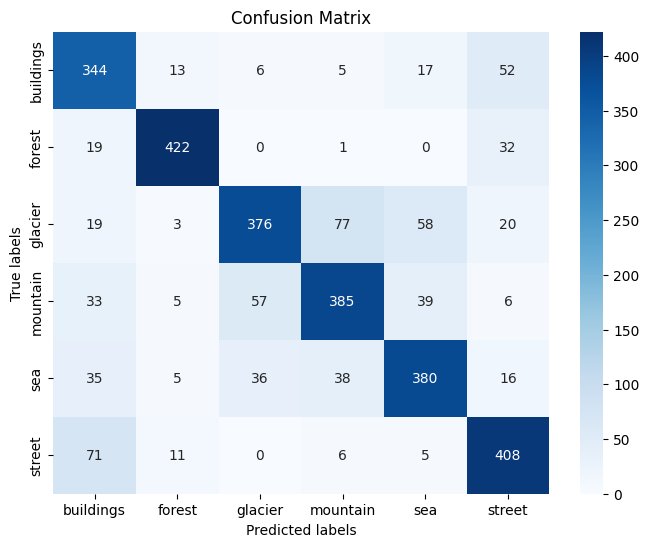

In [17]:
# Evaluación del modelo con los datos de prueba
test_loss, test_accuracy = model.evaluate(X_test, y_test_encoded, verbose = 0)
print(f"Accuracy on test data: {test_accuracy}")
print(f"Loss on test data: {test_loss}")

# Predicciones del modelo en los datos de prueba
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis = 1)

# Mostrar el reporte de clasificación
print("\nClassification Report:")
print(classification_report(y_test_encoded, y_pred_classes))

# Mostrar la matriz de confusión
conf_matrix = confusion_matrix(y_test_encoded, y_pred_classes)
plt.figure(figsize = (8, 6))
sns.heatmap(conf_matrix, annot = True, fmt = "d", cmap = "Blues", 
            xticklabels=label_encoder.classes_, 
            yticklabels=label_encoder.classes_)
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title("Confusion Matrix")
plt.show()


### Ejercicio 9 

Representa algunos de los paisajes donde el modelo comete errores y muestra la confianza que tenía en ellos.





94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


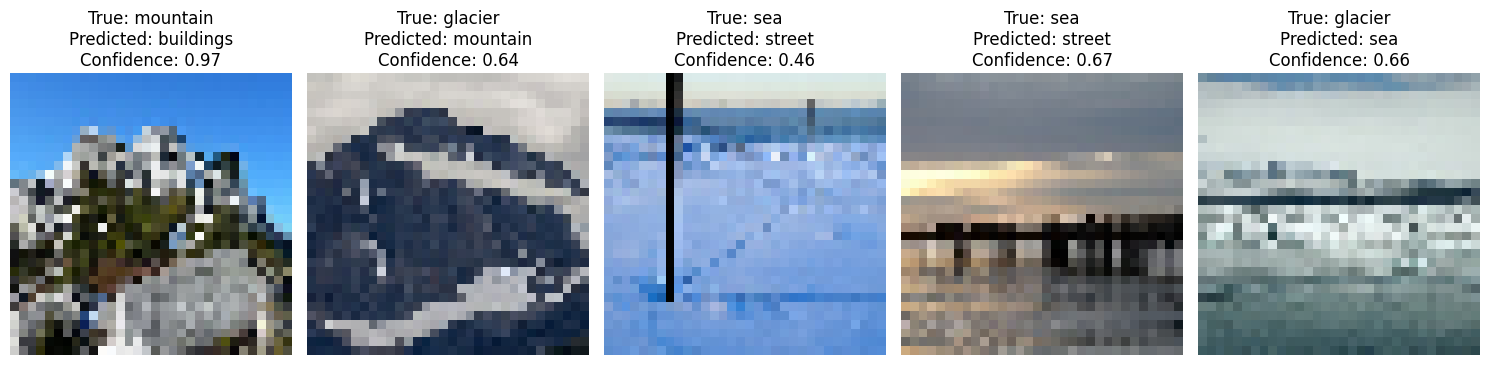

In [18]:
# Obtener las predicciones del modelo en los datos de prueba
y_pred_prob = model.predict(X_test)
y_pred_classes = np.argmax(y_pred_prob, axis = 1)

# Encontrar índices donde las predicciones son incorrectas
incorrect_indices = np.where(y_pred_classes != y_test_encoded)[0]

# Elegir aleatoriamente algunas imágenes donde el modelo se equivocó
num_images = 5  # Número de imágenes a mostrar
random_indices = np.random.choice(incorrect_indices, num_images, replace = False)

# Mostrar las imágenes junto con la etiqueta verdadera, etiqueta predicha y confianza
plt.figure(figsize = (15, 10))
for i, idx in enumerate(random_indices):
    image = X_test[idx]
    true_label = label_encoder.inverse_transform([y_test_encoded[idx]])[0]
    predicted_label = label_encoder.inverse_transform([y_pred_classes[idx]])[0]
    confidence = y_pred_prob[idx][y_pred_classes[idx]]  # Confianza en la predicción incorrecta

    plt.subplot(1, num_images, i + 1)
    plt.imshow(image)
    plt.title(f"True: {true_label}\nPredicted: {predicted_label}\nConfidence: {confidence:.2f}")
    plt.axis("off")

plt.tight_layout()
plt.show()

### Ejercicio EXTRA: 

Aumenta la resolución y repite el ejercicio con la misma topología de red